# **Fake It 'til You Make It: Exposing Fake News with AI**

Hello again! Welcome to the last blog post of our Python for Beginners series! Today, we will be using Text Classification to help solve one of the most pressing challenges of the digital age — fake news.

Misinformation from fake news spreads like wildfire, shaping public opinion and even influencing democratic processes along the way.

*But can we use AI to help us fight back?*

In this post, we’ll build and evaluate a fake news classifier using Keras, using text classification to determine whether a news article is real or not.

Our dataset comes from research by Ahmed, Traore, and Saad (2017), who explored fake news detection using N-Gram Analysis and Machine Learning. We’ll take their findings a step further by using deep learning to train models that analyze article titles, full text, or both.

Let’s get started and see if AI can separate fact from fiction!

## Set Up Project

Before we dive into building our fake news classifier, let’s start by importing all the necessary libraries. These will help us with everything from data processing to model training and evaluation.

In [ ]:
# Import libraries
import re
import nltk
import keras
import string
import numpy as np
import pandas as pd
from keras import utils
import tensorflow as tf
from keras import layers
import plotly.express as px
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import tensorflow_datasets as tfds
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TextVectorization, Embedding, Dense, Dropout, GlobalAveragePooling1D, Concatenate

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Step 1: Acquiring Training Data
Now that we have set up our environment, it’s time to load in our data! Our dataset can be accessed in two easy ways:

1.   Read it directly into Python using pd.read_csv()
2.   Download it to your computer and load it from disk

To keep it simple, let’s go with the first approach:

In [ ]:
# URL to the dataset
train_url = "https://raw.githubusercontent.com/pic16b-ucla/25W/refs/heads/main/datasets/fake_news_train.csv"

In [ ]:
# Pandas version of dataset
data = pd.read_csv(train_url)

Let's take a quick peek to see what our data looks like:

In [ ]:
# Visualize dataset
data.head()

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


This dataset is structured as follows:

- **title** – The headline of the article.
- **text** – The full body of the article.
- **fake** – A binary label:
    - 0 → The article is real.
    - 1 → The article is fake.

## Step 2: Make Dataset Function
Before we can train our model, we have to first prepare our dataset. We will clean and transform the raw text data into a format that TensorFlow can process efficiently. To do this, we create a function called make_dataset that preprocesses our data:

1.   **Text Cleaning** – The function first standardizes the text by converting it to lowercase, and filtering out stopwords (common words like 'the', 'and', 'but', that don’t add meaning).
2.   **Dataset Construction** – It then converts the processed data into a tf.data.Dataset, with each sample consisting of two inputs: the title and the article text, and one output: the fake news label (0 for real news, 1 for fake news).
3.   **Batching for Efficiency** – Finally, the dataset is shuffled and batched to improve training speed. A batch size of 100 is used to balance performance and accuracy.

Here is how to implement the function:

In [ ]:
# Make Dataset Function
def make_dataset(url):
  # Read dataset to Pandas
  df = pd.read_csv(url)

  # Make title and text lowercase
  df["title"] = df["title"].str.lower()
  df["text"] = df["text"].str.lower()

  # df column names
  df.columns = ["Unnamed: 0", "title", "text", "fake"]

  # Remove stopwords in title and text
  df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
  df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

  # Get inputs (title, text) and output (fake label)
  titles = df['title'].values
  texts = df['text'].values
  labels = df['fake'].values.astype(np.int32)

  # Create a Dataset
  dataset = tf.data.Dataset.from_tensor_slices(((titles, texts), labels))
  dataset = dataset.batch(100).prefetch(tf.data.experimental.AUTOTUNE)

  # Return
  return dataset

In [ ]:
# Dataset
data = make_dataset(train_url)

## Step 3: Split Data for Validation
To make sure our model generalizes well to unseen data, we need to split our dataset into training (80%) and validation (20%) sets. The training set is used to optimize the model, while the validation set helps us evaluate performance and detect overfitting.

**Steps:**
1.   **Count the Total Samples** – Since tf.data.Dataset does not have a built-in len() function, we use the reduce() method to iterate through the dataset and count its elements.
2.   **Determine Split Sizes** – We calculate 80% of the total dataset size for training, which leaves 20% for validation.
3.   **Use take() and skip()** – We use .take(train_size) to get the first 80% of the dataset for training and .skip(train_size) to get the remaining 20% for validation.

Here’s the implementation:

In [ ]:
# Split the dataset into training (80%) and validation (20%)

# Count total elements in dataset
dataset_size = data.reduce(0, lambda x, _: x + 1).numpy()

# Define split sizes
train_size = int(0.8 * dataset_size)

# Split dataset
# Take first 80% of the dataset
train_ds = data.take(train_size)
# Skip first 80% and take remaining 20%
val_ds = data.skip(train_size)

## Step 4: Base Rate
Another step before training our model is to determine the base rate accuracy — the accuracy a model would achieve by always predicting the most frequent class. This gives us a benchmark to compare our trained model against.

**Steps:**

1.   **Extract Labels** – Since our dataset is in tf.data.Dataset format, we need to extract the labels using .unbatch() and .map().
2.   **Count the Labels** – We count how many articles are labeled as true (0) and how many are labeled as fake (1).
3.   **Calculate Baseline Accuracy** – The base rate is the proportion of the majority class in the dataset.

In [ ]:
# Labels iterator
labels_iterator = train_ds.unbatch().map(lambda inputs, label: label).as_numpy_iterator()

In [ ]:
# Examine labels
labels = np.array(list(labels_iterator))

# Count true and false
num_true = np.sum(labels == 0)
num_false = np.sum(labels == 1)

# Print
print(f"Number of True Articles: {num_true}")
print(f"Number of False Articles: {num_false}")

Number of True Articles: 8603
Number of False Articles: 9397


In [ ]:
# Baseline Accuracy
total = num_true + num_false
baseline = (max(num_true, num_false) / total) * 100
print(f"Baseline accuracy: {baseline:.2f}%")

Baseline accuracy: 52.21%


## Step 5: Creating Models

Now, it's time to get to the good stuff! In natural language processing (NLP), the way we preprocess and encode textual data impacts model performance. To build our fake news detection model, we have multiple inputs, such as titles and text. Usually, these inputs are processed separately, but a shared vectorization and embedding layer makes sure our models are consistent (same words have the same vector representation in title and text) and efficient (eliminates redundance embedding layers to reduce memory usage and model complexity).

We will implement a shared vectorization and embedding layer to power three different models:

1.   Title-Only Model

2.   Text-Only Model

3.   Combined Title + Text Model

Here is the implementation:


In [ ]:
# Preparing a shared text vectorization layer for tf model
size_vocabulary = 2000

# Standardization function
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')
    return no_punctuation

# Shared Text Vectorization Layer
shared_vectorize_layer = layers.TextVectorization(
                                                  standardize=standardization,
                                                  max_tokens=size_vocabulary,
                                                  output_mode='int',
                                                  output_sequence_length=500
                                                 )
# Access both title and text
shared_vectorize_layer.adapt(train_ds.map(lambda x, y: tf.concat([x[0], x[1]], axis=0)))

In [ ]:
# Shared Embedding Layer
shared_embedding = layers.Embedding(input_dim=size_vocabulary, output_dim=16)

Here, shared_vectorize_layer tokenizes and converts input text into numerical sequences, while shared_embedding_layer maps these sequences into dense vector representations.

### Title-Only Model


In [ ]:
# Functional API for Title Model
# Title Input Layer
title_input = keras.Input(shape=(1,), dtype=tf.string, name="title_input")

# Shared vectorization and embedding layers
title_vectors = shared_vectorize_layer(title_input)
title_embeddings = shared_embedding(title_vectors)

# Rest of the layers
# Converts sequence into a single vector
x = layers.GlobalAveragePooling1D()(title_embeddings)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)

# Output layer
# Binary classification
output = layers.Dense(1, activation="sigmoid")(x)

In [ ]:
# Define the model
title_model = keras.Model(inputs=title_input, outputs=output, name="Title_Only_Model")

In [ ]:
# Compile the model
title_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [ ]:
# Train the Model
history = title_model.fit(
    # Extract title and label
    train_ds.map(lambda x, y: (x[0], y)),
    # Extract title and label
    validation_data=val_ds.map(lambda x, y: (x[0], y)),
    epochs=20,
    batch_size=100
)

Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5145 - loss: 0.6925 - val_accuracy: 0.5266 - val_loss: 0.6908
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5357 - loss: 0.6899 - val_accuracy: 0.7341 - val_loss: 0.6796
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6034 - loss: 0.6693 - val_accuracy: 0.7620 - val_loss: 0.6087
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6937 - loss: 0.5981 - val_accuracy: 0.7732 - val_loss: 0.5148
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7486 - loss: 0.5207 - val_accuracy: 0.7946 - val_loss: 0.4619
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7621 - loss: 0.4876 - val_accuracy: 0.8038 - val_loss: 0.4303
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7840 - loss: 0.4535 - val_accuracy: 0.8197 - val_loss: 0.4069
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8038 - loss: 0.4213 - val_accu

#### Validation Accuracy for Title-Only Model

In [ ]:
# Evaluate model
val_loss, val_acc = title_model.evaluate(val_ds.map(lambda x, y: (x[0], y)))
print(f"Validation Accuracy: {val_acc:.2f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9026 - loss: 0.2368
Validation Accuracy: 0.90


#### Visualizations
We will create a function that we can use for the rest of the models to plot Training and Validation Accuracy/Loss to keep track of how our models do throughout the epochs.

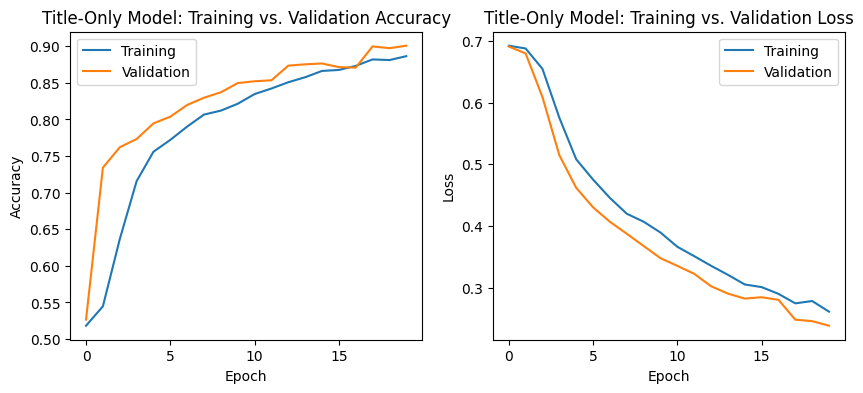

In [ ]:
# Create figure
plt.figure(figsize=(10,4))

# Plot Training vs. Validation Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label = "Training")
plt.plot(history.history["val_accuracy"], label = "Validation")
plt.gca().set(xlabel = "Epoch", ylabel = "Accuracy")
plt.title("Title-Only Model: Training vs. Validation Accuracy")
plt.legend()

# Plot Training vs. Validation Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label = "Training")
plt.plot(history.history["val_loss"], label = "Validation")
plt.gca().set(xlabel = "Epoch", ylabel = "Loss")
plt.title("Title-Only Model: Training vs. Validation Loss")
plt.legend()

# Show
plt.show()

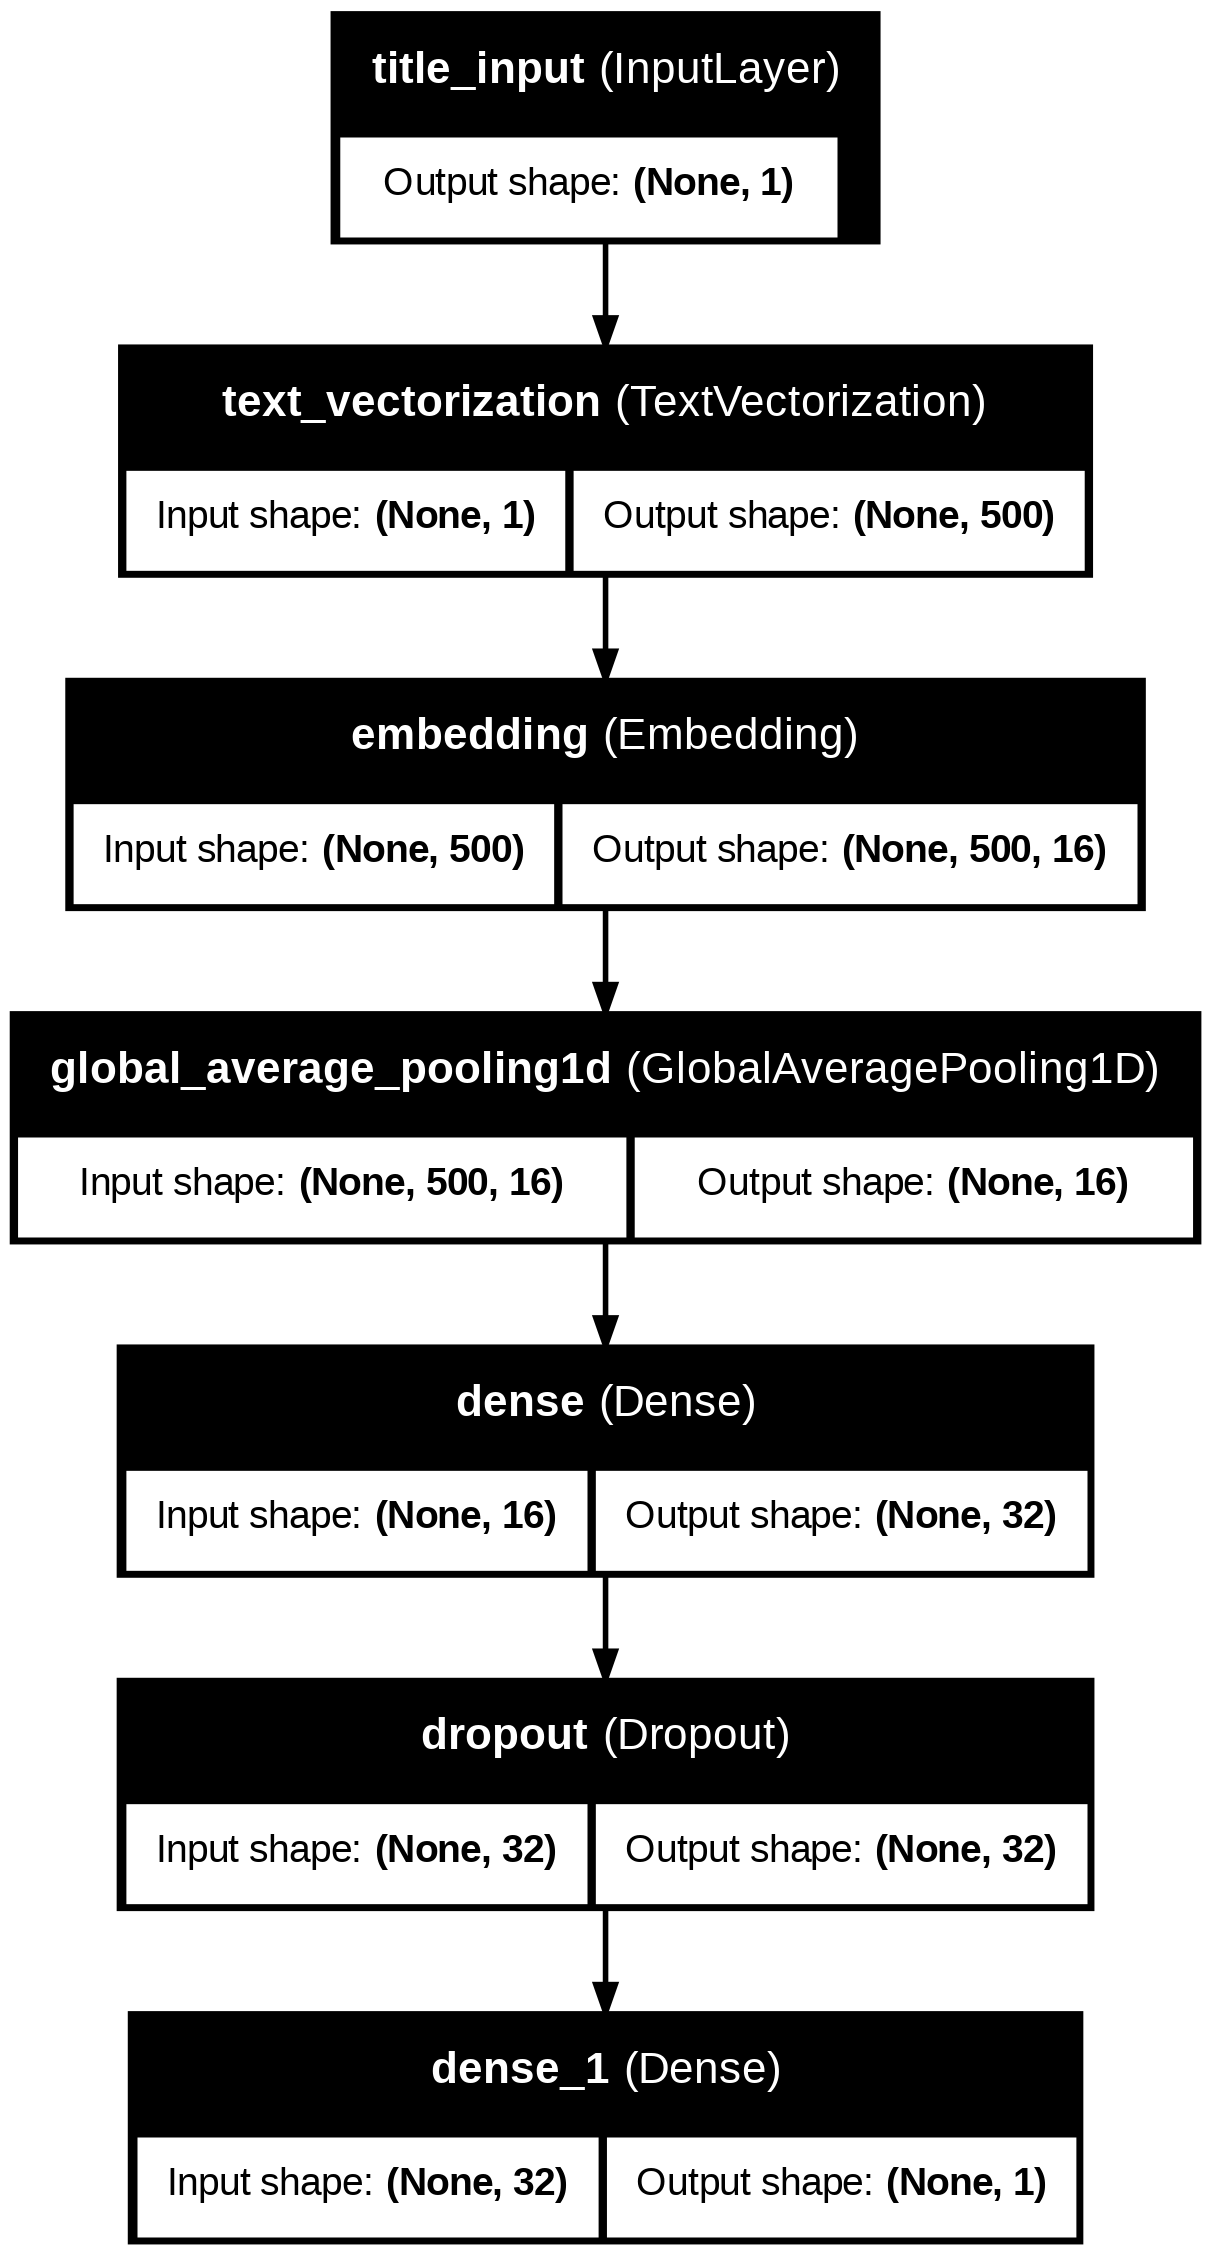

In [ ]:
# Visualization for title model
utils.plot_model(title_model, "title_visualization.png",
                       show_shapes=True,
                       show_layer_names=True)

#### Analysis
The title-only model achieving 90% validation accuracy is quite impressive,  considering the fact that it is only using the title of the article. This suggests that the title alone must contain a lot of important information for distinguishing between real vs. fake news. The model is effectively capturing key features from just a short, high-level summary of the content, which is a positive indicator of the model's ability to generalize from minimal information.

### Text-Only Model

In [ ]:
# Functional API for Text Model
# Text Input Layer
text_input = keras.Input(shape=(1,), dtype=tf.string, name="text_input")

# Shared vectorization and embedding layers
text_vectors = shared_vectorize_layer(text_input)
text_embeddings = shared_embedding(text_vectors)

# Rest of the layers
# Converts sequence into a single vector
x = layers.GlobalAveragePooling1D()(text_embeddings)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)

# Output layer
output = layers.Dense(1, activation="sigmoid")(x)

In [ ]:
# Define the model
text_model = keras.Model(inputs=text_input, outputs=output, name="Text_Only_Model")

In [ ]:
# Compile the model
text_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [ ]:
# Train the Model
history = text_model.fit(
    train_ds.map(lambda x, y: (x[1], y)), # Extract text and label
    validation_data=val_ds.map(lambda x, y: (x[1], y)), # Extract text and label
    epochs=20,  # Adjust epochs based on overfitting
    batch_size=100
)

Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6196 - loss: 0.6552 - val_accuracy: 0.8546 - val_loss: 0.4592
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8534 - loss: 0.4076 - val_accuracy: 0.8887 - val_loss: 0.2883
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9047 - loss: 0.2692 - val_accuracy: 0.9310 - val_loss: 0.2111
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9288 - loss: 0.2141 - val_accuracy: 0.9562 - val_loss: 0.1735
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9405 - loss: 0.1852 - val_accuracy: 0.9616 - val_loss: 0.1502
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9486 - loss: 0.1616 - val_accuracy: 0.9622 - val_loss: 0.1378
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9497 - loss: 0.1484 - val_accuracy: 0.9658 - val_loss: 0.1237
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9554 - loss: 0.1360 - val_accu

#### Validation Accuracy for Text-Only Model

In [ ]:
# Evaluate model
val_loss, val_acc = text_model.evaluate(val_ds.map(lambda x, y: (x[1], y)))
print(f"Validation Accuracy: {val_acc:.2f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9777 - loss: 0.0740
Validation Accuracy: 0.97


#### Visualizations

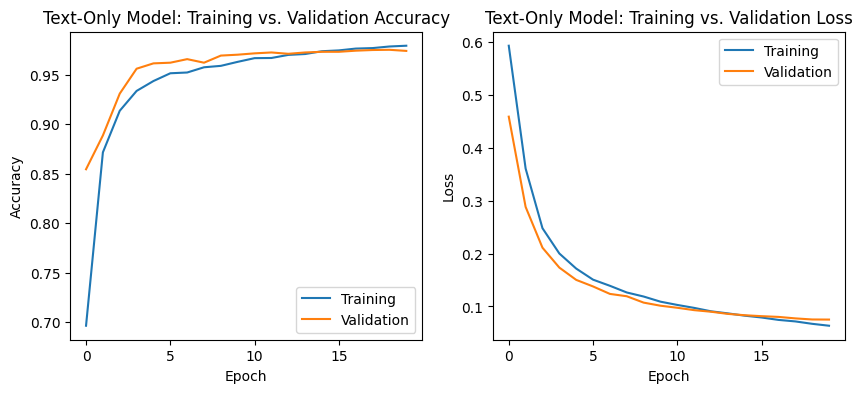

In [ ]:
# Create figure
plt.figure(figsize=(10,4))

# Plot Training vs. Validation Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label = "Training")
plt.plot(history.history["val_accuracy"], label = "Validation")
plt.gca().set(xlabel = "Epoch", ylabel = "Accuracy")
plt.title("Text-Only Model: Training vs. Validation Accuracy")
plt.legend()

# Plot Training vs. Validation Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label = "Training")
plt.plot(history.history["val_loss"], label = "Validation")
plt.gca().set(xlabel = "Epoch", ylabel = "Loss")
plt.title("Text-Only Model: Training vs. Validation Loss")
plt.legend()

# Show
plt.show()

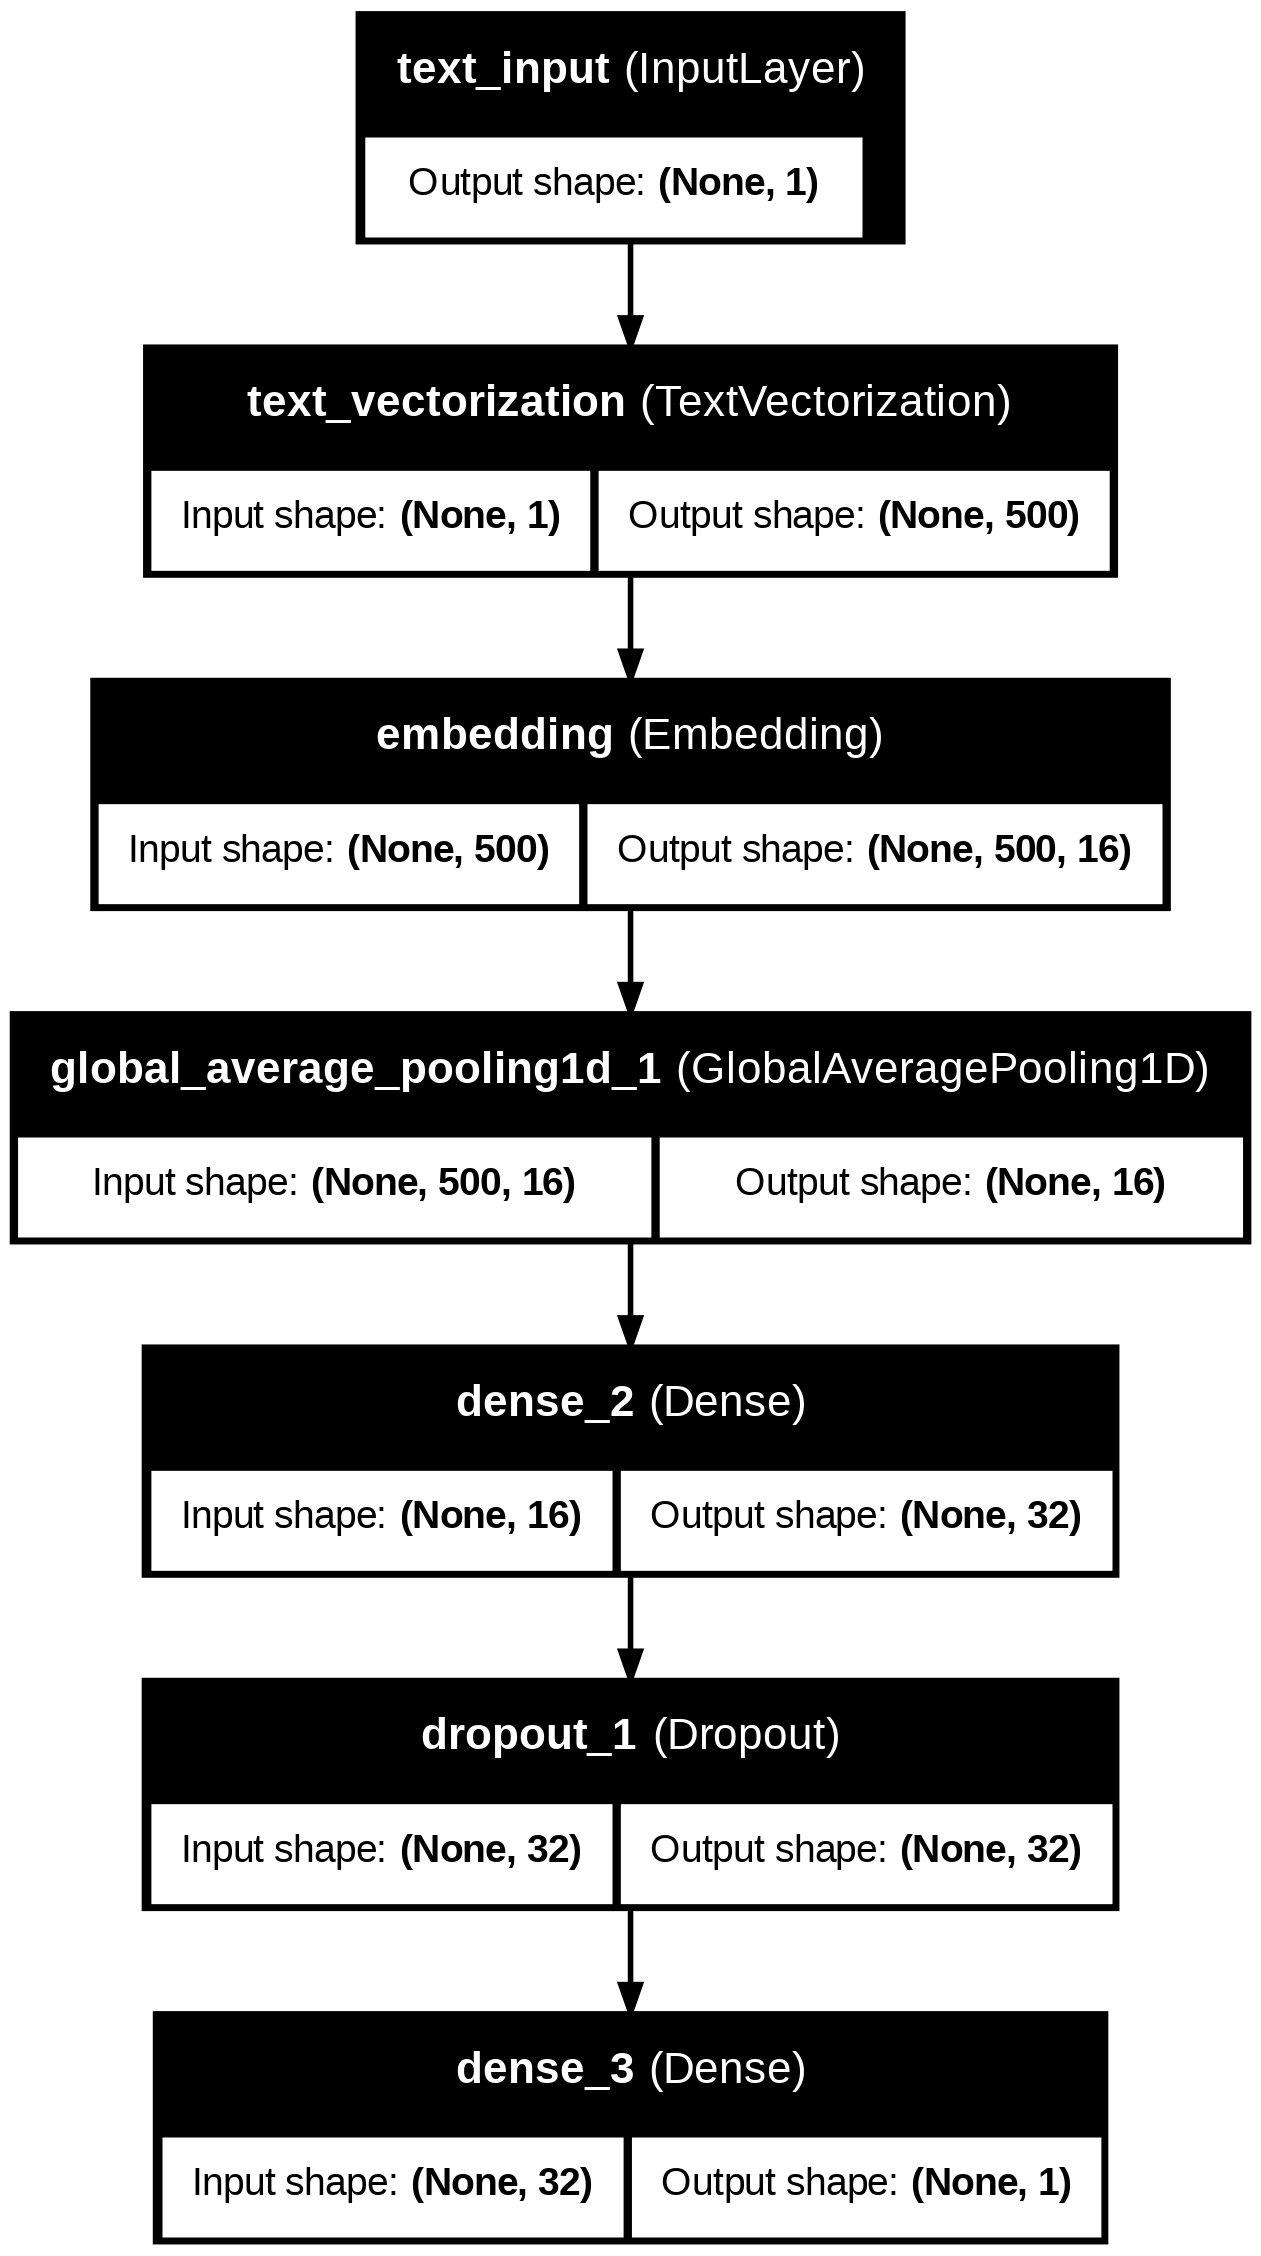

In [ ]:
# Visualization for title model
utils.plot_model(text_model, "text_visualization.png",
                       show_shapes=True,
                       show_layer_names=True)

#### Analysis
The text-only model achieving a 97% validation accuracy is a sizable improvement over the title-only model's 90%. This suggests that the full text provides more valuable information for distinguishing between classes like real vs. fake news compared to just the title. The increase in accuracy means that the body of the text contains additional context, details, and subtle cues that the model can use to make more informed predictions.

### Combined Title + Text Model

In [ ]:
# Title Input
title_input = keras.Input(shape=(1,), dtype=tf.string, name="title_input")
title_vectors = shared_vectorize_layer(title_input)
title_embeddings = shared_embedding(title_vectors)
title_output = layers.GlobalAveragePooling1D()(title_embeddings)

# Text Input
text_input = keras.Input(shape=(1,), dtype=tf.string, name="text_input")
text_vectors = shared_vectorize_layer(text_input)
text_embeddings = shared_embedding(text_vectors)
text_output = layers.GlobalAveragePooling1D()(text_embeddings)

# Combinining inputs
merged = layers.concatenate([title_output, text_output])

# Fully connected layers
x = layers.Dense(64, activation="relu")(merged)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)

# Output Layer
final_output = layers.Dense(1, activation="sigmoid")(x)

In [ ]:
# Define the model
combined_model = keras.Model(inputs=[title_input, text_input], outputs=final_output, name="Title_Text_Model")

In [ ]:
# Compile Model
combined_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [ ]:
# Train Model
history = combined_model.fit(
    # Get title, text, and labels
    train_ds.map(lambda x, y: ((x[0], x[1]), y)),
    # Get title, text, and labels
    validation_data=val_ds.map(lambda x, y: ((x[0], x[1]), y)),
    epochs=20,
    batch_size=100
)

Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7980 - loss: 0.4460 - val_accuracy: 0.9634 - val_loss: 0.1102
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9672 - loss: 0.1036 - val_accuracy: 0.9616 - val_loss: 0.1036
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9703 - loss: 0.0873 - val_accuracy: 0.9676 - val_loss: 0.0893
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9803 - loss: 0.0649 - val_accuracy: 0.9742 - val_loss: 0.0736
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9823 - loss: 0.0571 - val_accuracy: 0.9652 - val_loss: 0.0936
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9817 - loss: 0.0545 - val_accuracy: 0.9753 - val_loss: 0.0707
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9863 - loss: 0.0467 - val_accuracy: 0.9762 - val_loss: 0.0659
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9860 - loss: 0.0423 - val_accu

#### Validation Accuracy for Title + Text Model

In [ ]:
val_loss, val_acc = combined_model.evaluate(
    val_ds.map(lambda x, y: ((x[0], x[1]), y))
)

# Print Validation Accuracy
print(f"Validation Accuracy: {val_acc:.2f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9872 - loss: 0.0561
Validation Accuracy: 0.98


#### Visualizations

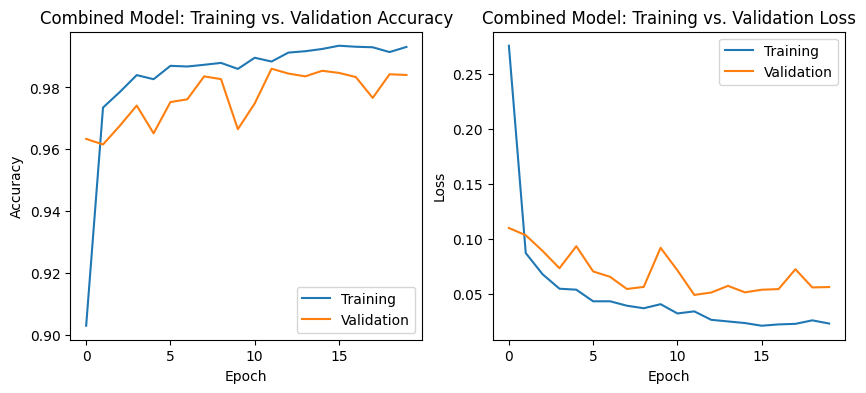

In [ ]:
# Create figure
plt.figure(figsize=(10,4))

# Plot Training vs. Validation Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label = "Training")
plt.plot(history.history["val_accuracy"], label = "Validation")
plt.gca().set(xlabel = "Epoch", ylabel = "Accuracy")
plt.title("Combined Model: Training vs. Validation Accuracy")
plt.legend()

# Plot Training vs. Validation Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label = "Training")
plt.plot(history.history["val_loss"], label = "Validation")
plt.gca().set(xlabel = "Epoch", ylabel = "Loss")
plt.title("Combined Model: Training vs. Validation Loss")
plt.legend()

# Show
plt.show()

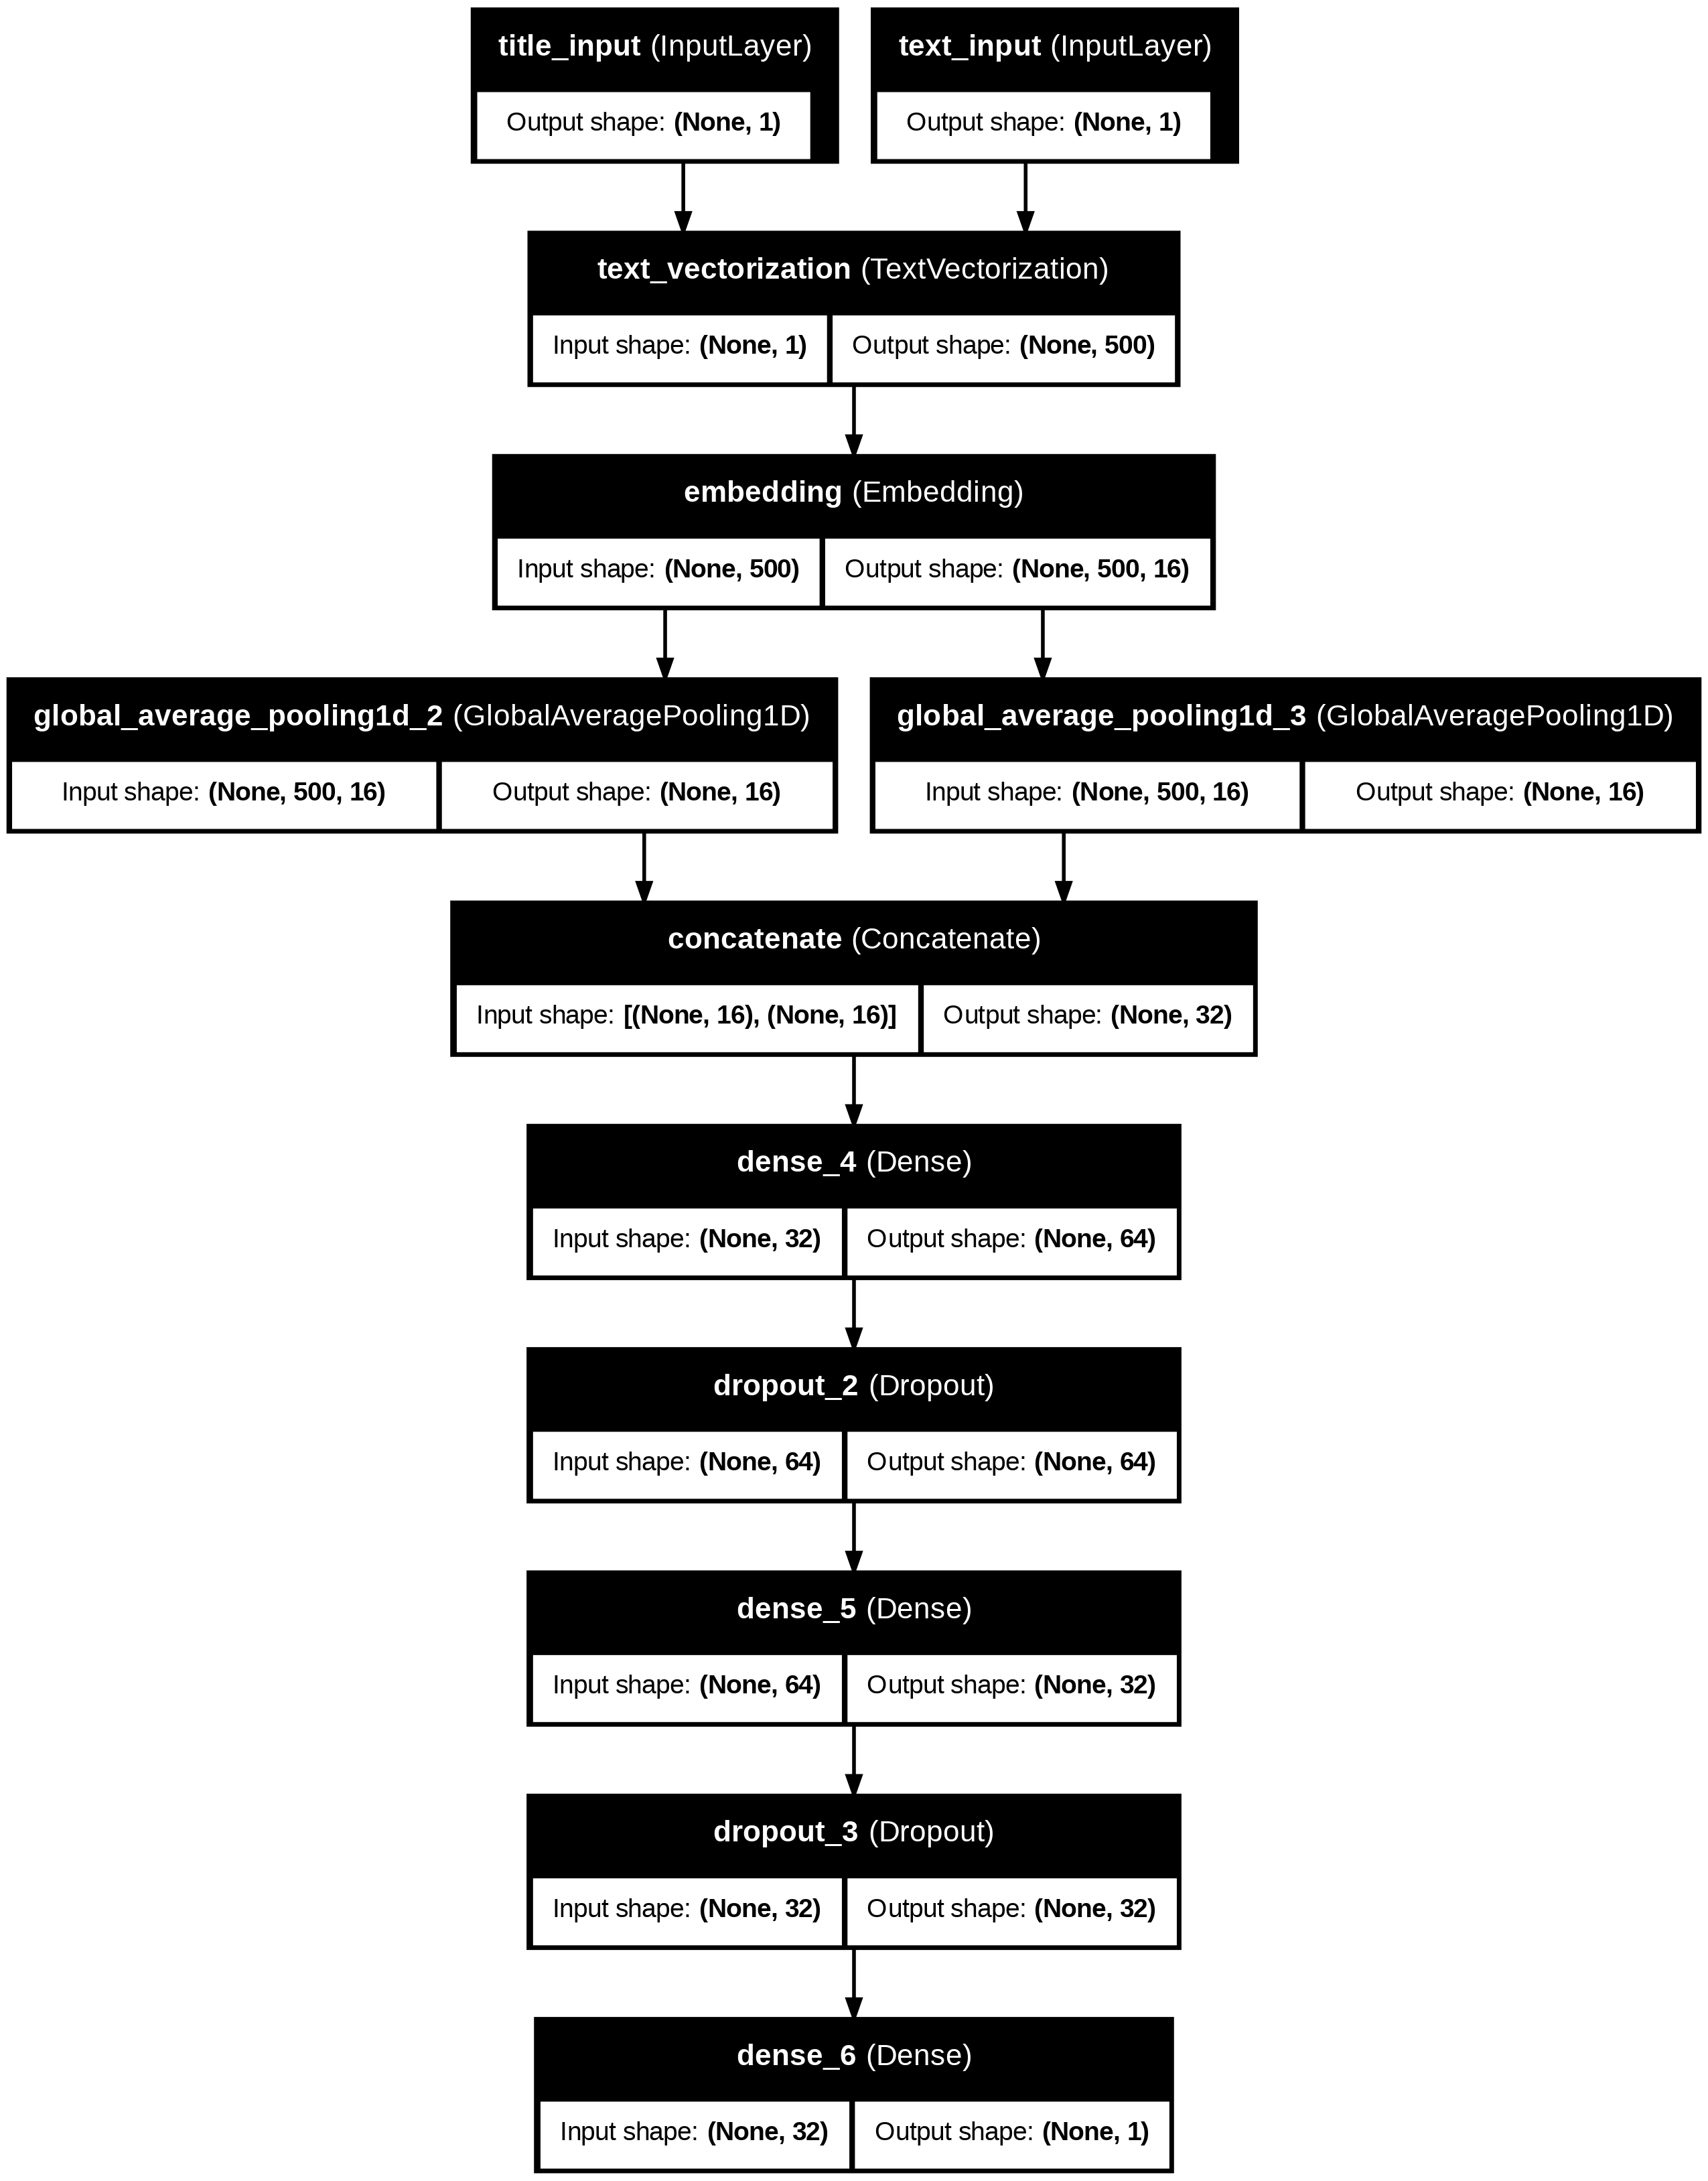

In [ ]:
# Visualization for title model
utils.plot_model(combined_model, "combined_visualization.png",
                       show_shapes=True,
                       show_layer_names=True)

#### Analysis
The combined model achieving a 98% validation accuracy shows an improvement of 8% over the title-only model, but only a 1% improvement over the text-only model. This suggests that while combining the title and the full text provides some added value, the majority of the performance boost likely comes from the full text itself.

The large jump from the title-only model to the combined model reflects how the title can still contribute useful information, even though it may not be as rich as the full article. The fact that the improvement over the text-only model is only 1% implies that the full text already captures most of the necessary features for accurate classification, and adding the title does not introduce much additional useful information.

## Step 6: Evaluating Model Performance on Unseen Data
Now that we’ve fine-tuned our model and optimized its performance on validation data, it’s time for the ultimate test: unseen data. Evaluating our best model on fresh, unencountered samples will help us see how well our model generalizes beyond the training set.

#### Test Data

In [ ]:
test_url = "https://raw.githubusercontent.com/pic16b-ucla/25W/refs/heads/main/datasets/fake_news_test.csv"

To have consistent results, we’ll preprocess this data using the same make_dataset function we defined earlier. This will standardize formatting, tokenize the text appropriately, and prepare it for evaluation.

In [ ]:
# Dataset
test_data = make_dataset(test_url)

#### Evaluate the Model

In [ ]:
# Evaluate the model
test_loss, test_accuracy = combined_model.evaluate(test_data)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Evaluate the model on validation data
val_loss, val_accuracy = combined_model.evaluate(val_ds)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9842 - loss: 0.0576
Test Accuracy: 0.9833
Test Loss: 0.0595
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9872 - loss: 0.0561
Validation Accuracy: 0.9840
Validation Loss: 0.0565


In [ ]:
weights = combined_model.get_layer('embedding').get_weights()[0] # get the weights from the embedding layer
vocab = shared_vectorize_layer.get_vocabulary()                # get the vocabulary from our data prep for later

In [ ]:
weights = combined_model.get_layer('embedding').get_weights()[0]

In [ ]:
print(weights.shape)

(2000, 16)


In [ ]:
pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

In [ ]:
weights.shape

(2000, 2)

In [ ]:
embedding_df = pd.DataFrame({
    'word' : vocab,
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})
embedding_df

,word,x0,x1
0,,0.458991,-0.369868
1,[UNK],-3.254118,3.480346
2,said,11.903173,7.233503
3,trump,-7.662038,3.243038
4,us,13.215361,-7.409301
...,...,...,...
1995,reaction,-4.046322,-2.003912
1996,ministers,3.829593,-2.292025
1997,wonder,-6.529799,-4.318990
1998,setting,-0.664706,0.334590


In [ ]:
fig = px.scatter(embedding_df,
                 x = "x0",
                 y = "x1",
                 size = list(np.ones(len(embedding_df))),
                 size_max = 3,
                 hover_name = "word")

fig.show()

#### Analysis


These words are all about structure, planning, and organization. "Law" and "Politics" are both about how society is run, dealing with rules, policies, and decisions. "Organization" and "Projects" are about groups or actions focused on reaching specific goals through planning and teamwork. The word "goal" connects everything, since all the other words are about setting and achieving goals, whether it’s in politics, law, organizations, or projects.
Their closeness shows they all involve systems or efforts to make things happen, which is why they are similar.